# SCOTCH Tutorial 

This file is meant to serve as a series of walkthroughs for a few use cases of the SCOTCH catalog. 

Questions should be directed to m.lokken@mail.utoronto.ca and gaglian2@illinois.edu.

### 0. Reading the data. 

In [71]:
import h5py 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib as mpl
import re 
import astropy.coordinates as coord
import astropy.units as u
import optax

scotch = h5py.File("/Users/agagliano/Documents/Research/SCOTCH/data/scotchtestfile.hdf5", "r")
print(scotch.keys())

<KeysViewHDF5 ['HostTable', 'TransientTable']>


## 1. Properties of Transient Host Galaxies

First, let's print the available transients in the host galaxy table: 

In [2]:
scotch_hosts = scotch['HostTable']
print(scotch_hosts.keys())

<KeysViewHDF5 ['AGN', 'KN', 'SLSN-I', 'SNII', 'SNIIb', 'SNIa', 'SNIb', 'SNIc', 'TDE']>


Next, let's look at the properties available for each host galaxy of a single class:

In [3]:
print(scotch_hosts['AGN'].keys())

<KeysViewHDF5 ['GID', 'T', 'TID', 'a0', 'a1', 'a_rot', 'b0', 'b1', 'dc2ID', 'ellipticity', 'logMstar', 'logSFR', 'mag_Y', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_z', 'magerr_Y', 'magerr_g', 'magerr_i', 'magerr_r', 'magerr_u', 'magerr_z', 'n0', 'n1', 'w0', 'w1', 'z']>


Now let's plot the stellar mass and star-formation rates of each host galaxy population, split by class.

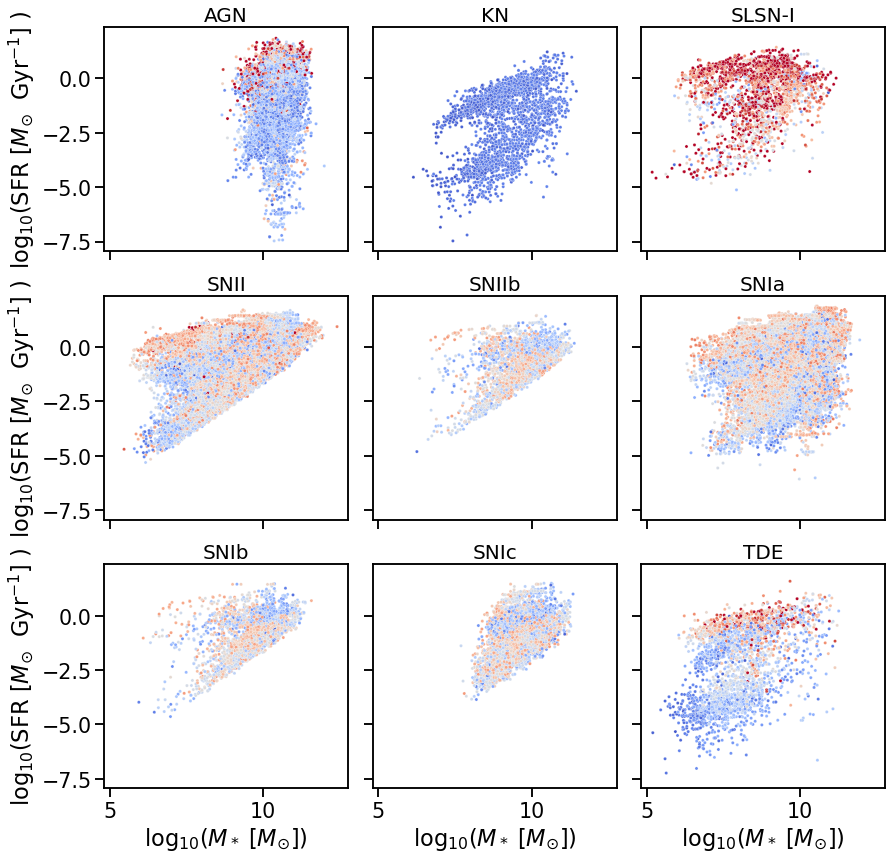

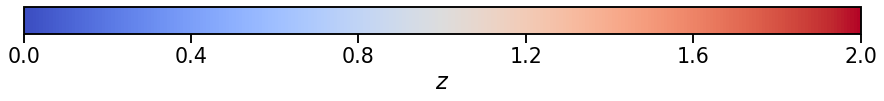

In [4]:
sns.set_context("talk",font_scale=1.25)
    
zmin = 0
zmax = 2

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 14), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)

for i in np.arange(len(scotch_hosts.keys())):
    transient = list(scotch_hosts.keys())[i]
    SFR = scotch_hosts[transient]['logSFR'][:] #host galaxy star-formation rate, in units of Msol/Gyr
    Mstar = scotch_hosts[transient]['logMstar'][:] #host galaxy stellar mass, in units of Msol
    z = scotch_hosts[transient]['z'][:] #true host galaxy redshift 
    ax = axs.ravel()[i]
    sns.scatterplot(x=Mstar, y=SFR, hue=z, palette='coolwarm', ax=ax, hue_norm=(zmin, zmax), legend=False, s=10)
    ax.set_title(transient, fontsize=20)
    ax.set_xlabel(r"log$_{10}(M_* \; [M_{\odot}])$")
    ax.set_ylabel(r"log$_{10}$(SFR [$M_{\odot} \;$ Gyr$^{-1}$] )")
    
fig, ax = plt.subplots(figsize=(15, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=zmin, vmax=zmax)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=np.linspace(zmin, zmax, 6))
cb1.set_label(r'$z$')

## 2. Recovering Transient Light Curves

Now let's look at the transients table. Let's start with one SN class, SNe II.

In [5]:
scotch_transients = scotch['TransientTable']

SNII = scotch_transients["SNII"]

Let's check what type-II SN models were run within SCOTCH.

In [6]:
print(SNII.keys())

<KeysViewHDF5 ['SNII+HostXT_V19', 'SNII-NMF', 'SNII-Templates', 'SNIIn+HostXT_V19', 'SNIIn-MOSFIT']>


More info on these models is provided in Lokken, Gagliano et al. 2022. Now let's plot the light curves of a single event for each SN II model.

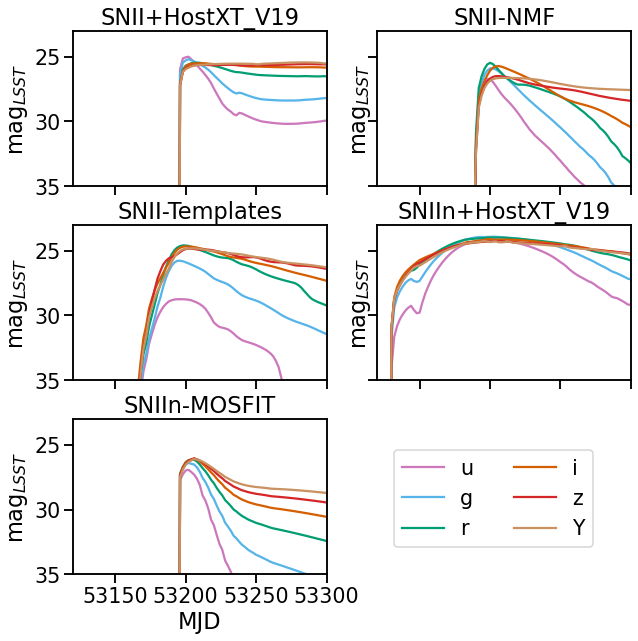

In [7]:
SNII_models = list(SNII.keys())

bands = 'ugrizY'
cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], 'tab:red', cols[7]], dtype='object') #u and y probably need changing

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        ax.plot(SNII_oneModel['MJD'][0], SNII_oneModel['mag_%s'%bands[j]][0], c=cols[j], label=bands[j])
    if i==0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

## 3. Survey-Specific Analyses

SCOTCH is intended as a truth catalog, but for many purposes the goal is to simulate observations taken by real surveys with specific footprints and limited efficiency. We provide a (very simple) example of how to emulate the LSST Deep Drilling Field below, using PLAsTiCC data as a comparison.

This example requires the metadata from the test set of the PLAsTiCC challenge, which can be downloaded from https://zenodo.org/record/2539456#.YmHSu5LMKNF. 

In [8]:
#Model 90 is SNIa 
#Model 42 is SNII
#Model 95 is SLSN-I
#only consider the DDF fields! We cut this using the `ddf_bool' field
plasticc = pd.read_csv("/Users/agagliano/Documents/Research/SCOTCH/data/plasticc/plasticc_test_metadata.csv")

plasticc_SNIa = plasticc[(plasticc['true_target'] == 90) & (plasticc['ddf_bool'] == 1)]
plasticc_SNII = plasticc[(plasticc['true_target'] == 42) & (plasticc['ddf_bool'] == 1)]
plasticc_SLSNI = plasticc[(plasticc['true_target'] == 95) & (plasticc['ddf_bool'] == 1)]

Now we loop through all our events, and cut the events that don't have at least 2 observations (in any band) above the 5-sigma DDF limit. 

In [9]:
#make cuts with a few classes to align with the 5-sigma depths simulated for LSST DDF: 
fiveSigma = {'u':25.05, 'g':25.49, 'r':25.57, 'i':25.18, 'z':24.79, 'Y':23.84}

survey_models = [scotch_transients['SNIa']['SNIa-SALT2'], scotch_transients['SLSN-I']['SLSN-I']]
keep_models = []
for model in survey_models:
    keep_idxs = []
    for i in np.arange(len(model['MJD'][:, 0])):
        sigCount = 0
        for band in 'ugrizY':
            sigCount += np.nansum(np.array(model['mag_%s'%band][i, :]) < fiveSigma[band])
        if sigCount > 2:
            keep_idxs.append(i)
    keep_models.append(keep_idxs)

If we plot the redshift distributions of the remaining events:

(0.0, 3.0)

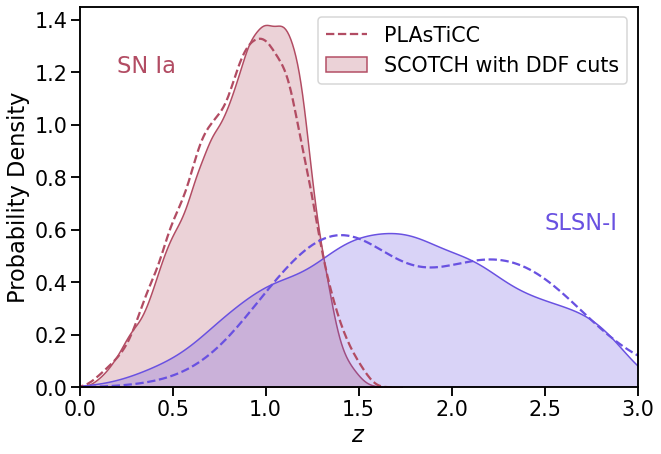

In [10]:
plt.figure(figsize=(10,7))
sns.kdeplot(survey_models[0]['z'][keep_models[0]], shade=True, color='#B24C63', label='SCOTCH with DDF cuts')
sns.kdeplot(survey_models[1]['z'][keep_models[1]], shade=True, color='#6951E1')
sns.kdeplot(plasticc_SNIa['true_z'], color='#B24C63', ls='--', label='PLAsTiCC')
sns.kdeplot(plasticc_SLSNI['true_z'],  color='#6951E1', ls='--')
plt.text(0.2, 1.2, "SN Ia", c='#B24C63')
plt.text(2.5, 0.6, "SLSN-I", c='#6951E1')
plt.legend()
plt.xlabel("$z$");
plt.ylabel("Probability Density");
plt.xlim((0, 3))

Pretty good! The remaining discrepancy is caused by the fact that we don't consider Milky Way extinction in SCOTCH, and the fact that observational cuts in SNANA are done with an efficiency vs SNR curve, not a delta function like we've used here. 

If we want to place SNe within the DDF fields on the sky, we can use a library of simulated DDF observations to characterize the DDF footprint. This is in the repository under `data/PLASTICC_ORIGINAL_DDF.SIMLIB`. Let's snag the coordinates of the observations: 

In [106]:
ra_ddf = []
dec_ddf = []
nobs = []

df_set = []
with open("/Users/agagliano/Documents/Research/SCOTCH/data/PLASTICC_ORIGINAL_DDF.SIMLIB", "r") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith("RA"):
            coords = re.findall(r"[-+]?\d*\.*\d+", line)
            ra_ddf.append(float(coords[0]))
            dec_ddf.append(float(coords[1]))
            df_obs = pd.DataFrame({'RA':[float(coords[0])], 'Dec':[float(coords[1])]})
            df_set.append(df_obs)
df_full = pd.concat(df_set, ignore_index=True)

In [179]:
#color by the DDF 
df_full['DDF'] = 0
#df_full.loc[np.abs(df_full['RA'] - 352) < 10, 'DDF'] = 1
df_full.loc[np.abs(df_full['RA'] - 149) < 10, 'DDF'] = 1
df_full.loc[np.abs(df_full['RA'] - 30) < 10, 'DDF'] = 2
df_full.loc[np.abs(df_full['RA'] - 60) < 10, 'DDF'] = 3

/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_75370/4285286317.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection="mollweide")


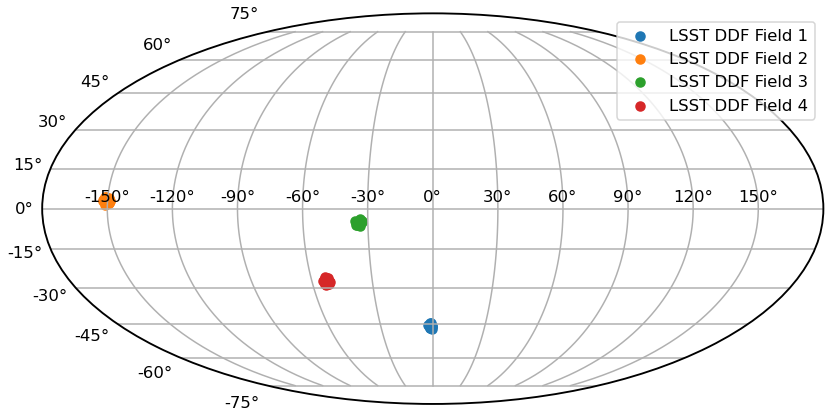

In [180]:
fig = plt.figure(figsize=(14,12))
for i in np.arange(len(np.unique(df_full['DDF']))):
    ddf = df_full[df_full['DDF'] == i]
    ra = coord.Angle(ddf['RA'], unit=u.deg)
    dec =  coord.Angle(ddf['Dec'], unit=u.deg)

    ax = fig.add_subplot(111, projection="mollweide")
    ax.scatter(-ra.radian, dec.radian, label='LSST DDF Field %i'%(i+1))
ax.grid(True)
plt.legend()

Now we'll use PZFlow to train a normalizing flow to understand the correlations between RA and DEC in the deep drilling fields, and sample the flow to generate new positions within the fields. These will be the locations of our transients on the sky.

Training 5000 epochs 
Loss:
(0) 9.3113
(1) 9.2609
(251) 4.3535
(501) 4.7150
(751) 4.1987
(1001) 4.0404
(1251) 3.9258
(1501) 3.8605
(1751) 3.8767
(2001) 4.4667
(2251) 3.7052
(2501) 3.6914
(2751) 3.5875
(3001) 4.1025
(3251) 4.0806
(3501) 3.9533
(3751) 3.8629
(4001) 3.7450
(4251) 4.3589
(4501) 3.6286
(4751) 3.4348
(5000) 3.3836


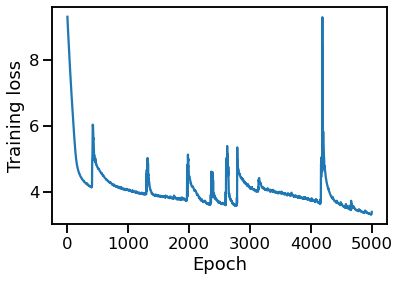

Training 5000 epochs 
Loss:
(0) 2.7409
(1) 2.7218
(251) 0.0412
(501) 0.3941
(751) 0.5317
(1001) 0.0933
(1251) 0.4941
(1501) -0.1837
(1751) -0.4697
(2001) -0.4337
(2251) -0.3458
(2501) -0.6149
(2751) -0.6564
(3001) 0.6148
(3251) 0.1935
(3501) 1.9418
(3751) 0.2449
(4001) 0.1839
(4251) 0.2010
(4501) 0.2173
(4751) -0.0712
(5000) -0.5374


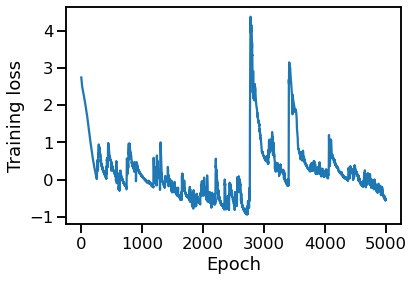

Training 5000 epochs 
Loss:
(0) 2.7771
(1) 2.7466
(251) -0.1204
(501) -0.0702
(751) 0.3205
(1001) -0.3745
(1251) -0.5819
(1501) -0.3620
(1751) -0.7615
(2001) -0.7480
(2251) -0.5244
(2501) -0.5604
(2751) 0.0866
(3001) 0.0957
(3251) -0.0378
(3501) -0.3253
(3751) 0.2977
(4001) -0.0559
(4251) 0.2297
(4501) 0.0979
(4751) 0.0610
(5000) -0.7590


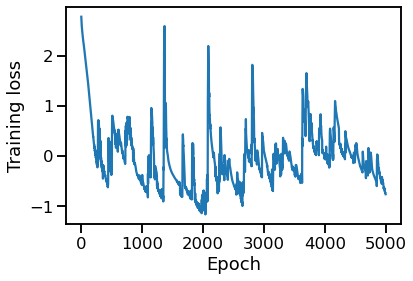

Training 5000 epochs 
Loss:
(0) 2.8820
(1) 2.8632
(251) 0.3298
(501) -0.0599
(751) 0.2252
(1001) -0.0826
(1251) 0.2849
(1501) 1.9510
(1751) 0.8629
(2001) 0.5148
(2251) 0.3661
(2501) -0.0697
(2751) -0.1586
(3001) 0.2131
(3251) 0.3013
(3501) 0.2602
(3751) 0.0210
(4001) -0.0107
(4251) -0.1404
(4501) -0.0110
(4751) -0.2820
(5000) 0.0180


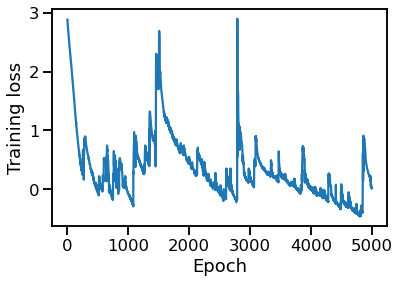

In [198]:
from pzflow import Flow
import jax.numpy as jnp

from pzflow import Flow
from pzflow.bijectors import Chain, NeuralSplineCoupling, Roll, StandardScaler, ShiftBounds
from pzflow.distributions import Joint, Normal, Uniform

sample_set = []
for i in np.arange(4):
    tempDF = df_full[df_full['DDF'] == i]
    flow = Flow(["RA", "Dec"])
    opt = optax.adam(1e-4)
    losses = flow.train(tempDF, optimizer=opt, epochs=5000, seed=0, verbose=True)
   # opt = optax.adam(1e-5)
  #  losses += flow.train(tempDF, optimizer=opt, epochs=2000, seed=1, verbose=True)

    #ignore the DDF for now 
    #del df_full['DDF']

    #mins = jnp.array(df_full.min(axis=0))
    #maxs = jnp.array(df_full.max(axis=0))

    #bijector = Chain(
    #    ShiftBounds(mins, maxs, 5),
    #    NeuralSplineCoupling(K=128, hidden_layers=4, n_conditions=1, transformed_dim=1),
    #    Roll(),
    #    NeuralSplineCoupling(K=128, hidden_layers=4,  n_conditions=1, transformed_dim=1),
    #    Roll(),
    #    NeuralSplineCoupling(K=128, hidden_layers=4,  n_conditions=1, transformed_dim=1, periodic=True),
    #    Roll(),
    #)

    #flow = Flow(["RA", "Dec"], bijector, conditional_columns=["DDF"])
    #opt = optax.adam(1e-4)
    #losses = flow.train(df_full, optimizer=opt, epochs=2000, seed=0, verbose=True)
    #opt = optax.adam(1e-5)
    #losses += flow.train(df_full, optimizer=opt, epochs=12000, seed=1, verbose=True)

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.show()
    
    #generate locations for 4k transients in each DDF
    samples = flow.sample(4000)
    samples['DDF'] = i
    sample_set.append(samples)
sample_df = pd.concat(sample_set)

In [199]:
sample_df = pd.concat(sample_set)

In [186]:
#conditional_DDF = pd.DataFrame({'DDF':np.concatenate([[0]*1000, [1]*1000, [2]*1000, [3]*1000])})
#samples = flow.sample(4000, conditions=conditional_DDF, seed=0)

Now let's make sure that our re-sampled positions look reasonable: 

/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_75370/242640264.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection="mollweide")


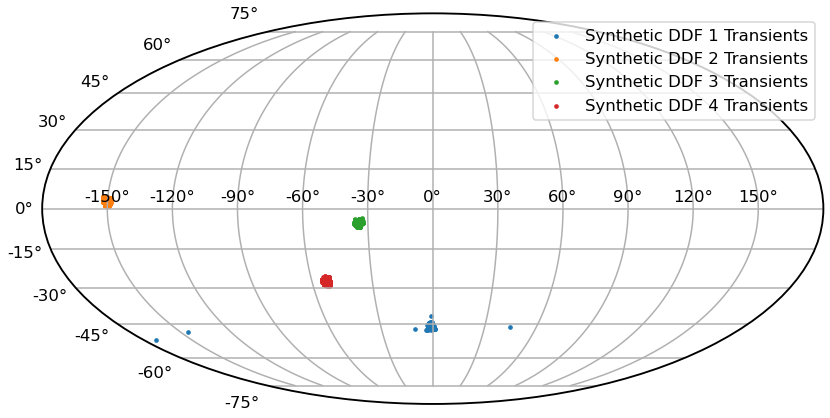

In [203]:
fig = plt.figure(figsize=(14,12))
for ddf in np.arange(4):
    sampled_ddf = sample_df[sample_df['DDF'] == ddf]
    ra = coord.Angle(sampled_ddf['RA'], unit=u.deg)
    dec =  coord.Angle(sampled_ddf['Dec'], unit=u.deg)

    ax = fig.add_subplot(111, projection="mollweide")
    ax.scatter(-ra.radian, dec.radian, label='Synthetic DDF %i Transients'%(ddf+1), s=10)
    ax.grid(True)
    plt.legend();

In [230]:
scotch_transients['SNIa']['SNIa-SALT2'].keys()

<KeysViewHDF5 ['GID', 'MJD', 'TID', 'cadence', 'dec_off', 'mag_Y', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_z', 'ra_off', 'sep', 'z']>

In [249]:
#Place 4k SNe Ia in DDF 2
#get the offsets and redshifts of galaxies and position them in the field
#TODO: Drop the zeros as soon as we get unique IDs!!
ddf2_transients = sample_df[sample_df['DDF'] == 2]
z = []
ra_off = []
dec_off = []

for TID in scotch_transients['SNIa']['SNIa-SALT2']['TID'][0:len(ddf2_transients)]:
    idx_transient = scotch_transients['SNIa']['SNIa-SALT2']['TID'][:] == TID
    idx_host = scotch_hosts['SNIa']['TID'][:] == TID
    z.append(scotch_hosts['SNIa']['z'][idx_host][0])
    ra_off.append(scotch_transients['SNIa']['SNIa-SALT2']['ra_off'][idx_transient][0])
    dec_off.append(scotch_transients['SNIa']['SNIa-SALT2']['ra_off'][idx_transient][0])  

In [254]:
#position the SNIa host galaxies within DDF 2
ddf2_transients['RA_off'] = ra_off
ddf2_transients['Dec_off'] = dec_off
ddf2_transients['z_host'] = z
ddf2_transients['RA_host'] = ddf2_transients['RA'] - ddf2_transients['RA_off']
ddf2_transients['Dec_host'] = ddf2_transients['Dec'] - ddf2_transients['Dec_off']

/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_75370/2748180272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddf2_transients['RA_off'] = ra_off
/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_75370/2748180272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddf2_transients['Dec_off'] = dec_off
/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_75370/2748180272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

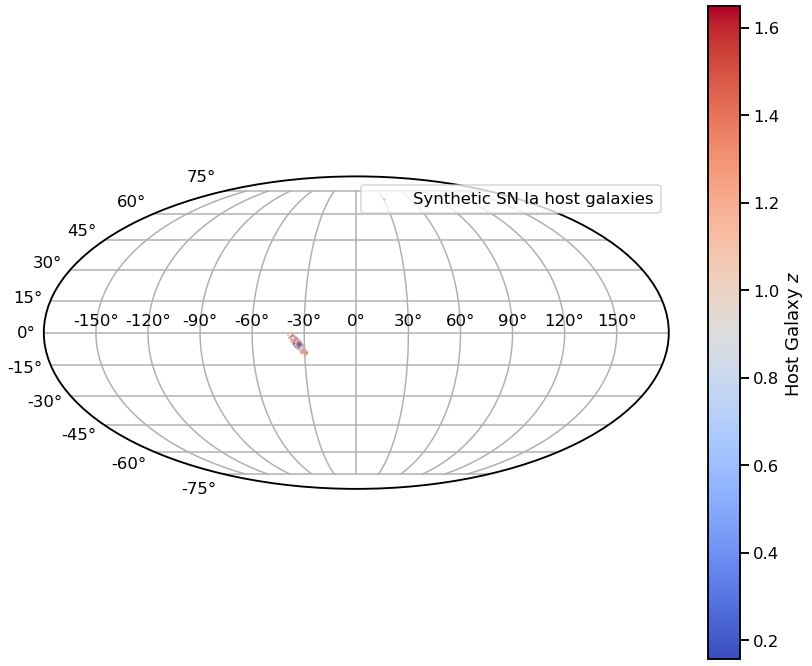

In [273]:
fig = plt.figure(figsize=(14,12))
ra = coord.Angle(ddf2_transients['RA_host'], unit=u.deg)
dec =  coord.Angle(ddf2_transients['Dec_host'], unit=u.deg)

ax = fig.add_subplot(111, projection="mollweide")
g = ax.scatter(-ra.radian, dec.radian, c=ddf2_transients['z_host'], cmap='coolwarm', label='Synthetic SN Ia host galaxies', s=0.1)
cbar = plt.colorbar(g)
cbar.set_label(r"Host Galaxy $z$")
ax.grid(True)
plt.legend();